In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
import glob
import pandas as pd
from sklearn.metrics import r2_score

In [2]:
files = sorted(glob.glob('/hurrell-scratch2/ivyglade/pdo/storm_reports/StormEvents_details-ftp_v1.0_d*.csv'))

In [3]:
# Import a single ERA5 file so that we have a lat/lon grid for reference
era5_data = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1940s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19400101-19491231.nc')

In [4]:
# Subset a CONUS box
era5_data_conus = era5_data['CAPE'].sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [5]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [6]:
# 3- month rolling mean
nino_34_rolling = nino_34.rolling(time=3, center=True).mean()
nino_34_rolling_1980_2024 = nino_34_rolling.sel(time=nino_34_rolling.time.dt.year.isin(np.arange(1980, 2025, 1)))
nino_34_rolling_1980_2024_mam = nino_34_rolling_1980_2024.sel(time=nino_34_rolling_1980_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

nino_34_calc = np.zeros((1860))
for i in range(1860):
    if i < 5:
        continue
    else:
        if (nino_34_rolling[(i-4)] > 0.5) & (nino_34_rolling[(i-3)] > 0.5) & (nino_34_rolling[(i-2)] > 0.5) & (nino_34_rolling[(i-1)] > 0.5) & (nino_34_rolling[i] > 0.5):
            nino_34_calc[i] = 1
        elif (nino_34_rolling[(i-4)] < -0.5) & (nino_34_rolling[(i-3)] < -0.5) & (nino_34_rolling[(i-2)] < -0.5) & (nino_34_rolling[(i-1)] < -0.5) & (nino_34_rolling[i] < -0.5):
            nino_34_calc[i] = -1
        else:
            continue

# convert nino_34_calc to xr
nino_34_calc_xr = xr.DataArray(nino_34_calc, coords={'time':sst['time']}, dims=['time'])

# 1940-2024 only
nino_34_1980_2024 = nino_34_calc_xr.sel(time=nino_34_calc_xr.time.dt.year.isin(np.arange(1980, 2025, 1)))
nino_34_1980_2024_mam = nino_34_1980_2024.sel(time=nino_34_1980_2024.time.dt.month.isin([3, 4, 5]))

In [7]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1980_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1980, 2025, 1)))
# nino_34_1940_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM
pdo_1980_2024_mam = pdo_1980_2024.sel(time=pdo_1980_2024.time.dt.month.isin([3, 4, 5])).groupby('time.year').mean()
# nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5])).groupby('time.year').mean()

# Need to calculate when El Nino/La Nina Occurs in a given year
nino_34_1980_2024_mam_ann = np.zeros((45))
for i in range(45):
    if nino_34_1980_2024_mam[i*3:i*3+3].sum(axis=0) > 0:
        nino_34_1980_2024_mam_ann[i] = 1

    elif nino_34_1980_2024_mam[i*3:i*3+3].sum(axis=0) < 0:
        nino_34_1980_2024_mam_ann[i] = -1

    else:
        continue

In [8]:
# Read and concatenate in order
storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)

/tmp/ipykernel_109611/3445745825.py:2: DtypeWarning: Columns (26,48) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_109611/3445745825.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_109611/3445745825.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_109611/3445745825.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  storm_reports = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
/tmp/ipykernel_109611/3445745825.py:2: DtypeWarning: Columns (29,34,35,37) have mixed type

In [9]:
storm_reports['BEGIN_YEARMONTH'] = pd.to_datetime(storm_reports['BEGIN_YEARMONTH'], format='%Y%m')
storm_reports['END_YEARMONTH'] = pd.to_datetime(storm_reports['END_YEARMONTH'], format='%Y%m')

In [10]:
# Extract the month
storm_reports["MONTH"] = storm_reports["BEGIN_YEARMONTH"].dt.month

In [11]:
# Specify different storm types
tornados = storm_reports[storm_reports['EVENT_TYPE'].isin(['Tornado'])]
hail = storm_reports[storm_reports['EVENT_TYPE'].isin(['Hail'])]
tstorm_wind = storm_reports[storm_reports['EVENT_TYPE'].isin(['Thunderstorm Wind'])]

In [12]:
# Subset storm reports by time periods
tornados_mam = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
tornados_mar = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([3])]
tornados_apr = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([4])]
tornados_may = tornados[tornados['BEGIN_YEARMONTH'].dt.month.isin([5])]

hail_mam = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
hail_mar = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([3])]
hail_apr = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([4])]
hail_may = hail[hail['BEGIN_YEARMONTH'].dt.month.isin([5])]

tstorm_wind_mam = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([3, 4, 5])]
tstorm_wind_mar = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([3])]
tstorm_wind_apr = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([4])]
tstorm_wind_may = tstorm_wind[tstorm_wind['BEGIN_YEARMONTH'].dt.month.isin([5])]

In [13]:
# Want to mess around with grid size a little bit to see if we can get a more coherent signal
lat_edges = np.append(era5_data_conus['latitude'].values-0.25, 23.5)
lon_edges = np.append(era5_data_conus['longitude'].values-0.25, 294)

lat_edges_0_5deg = lat_edges[::2]
lon_edges_0_5deg = lon_edges[::2]

In [14]:
tornado_counts_mam_separated = np.zeros((45, 50, 118))
for i in range(45):
    tornado_yr_mam = tornados_mam.loc[tornados_mam['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    # tornado_yr_mar = tornados_mar.loc[tornados_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    # tornado_yr_apr = tornados_apr.loc[tornados_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    # tornado_yr_may = tornados_may.loc[tornados_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tornado_counts_mam_separated[i] = pdo_functions.count_in_grid(tornado_yr_mam['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_mam['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    # tornado_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(tornado_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    # tornado_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(tornado_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    # tornado_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(tornado_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [15]:
hail_counts_mam_separated = np.zeros((45, 50, 118))
for i in range(45):
    hail_yr_mam = hail_mam.loc[hail_mam['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    # tornado_yr_mar = tornados_mar.loc[tornados_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    # tornado_yr_apr = tornados_apr.loc[tornados_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    # tornado_yr_may = tornados_may.loc[tornados_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    hail_counts_mam_separated[i] = pdo_functions.count_in_grid(hail_yr_mam['BEGIN_LAT'], pdo_functions.convert_longitudes(hail_yr_mam['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    # tornado_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(tornado_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    # tornado_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(tornado_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    # tornado_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(tornado_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [16]:
tstorm_wind_counts_mam_separated = np.zeros((45, 50, 118))
for i in range(45):
    tstorm_wind_yr_mam = tstorm_wind_mam.loc[tstorm_wind_mam['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    # tornado_yr_mar = tornados_mar.loc[tornados_mar['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    # tornado_yr_apr = tornados_apr.loc[tornados_apr['BEGIN_YEARMONTH'].dt.year == 1980 + i]
    # tornado_yr_may = tornados_may.loc[tornados_may['BEGIN_YEARMONTH'].dt.year == 1980 + i]

    tstorm_wind_counts_mam_separated[i] = pdo_functions.count_in_grid(tstorm_wind_yr_mam['BEGIN_LAT'], pdo_functions.convert_longitudes(tstorm_wind_yr_mam['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    # tornado_counts_mam_separated[(i*3)] = pdo_functions.count_in_grid(tornado_yr_mar['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_mar['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    # tornado_counts_mam_separated[(i*3)+1] = pdo_functions.count_in_grid(tornado_yr_apr['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_apr['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)
    # tornado_counts_mam_separated[(i*3)+2] = pdo_functions.count_in_grid(tornado_yr_may['BEGIN_LAT'], pdo_functions.convert_longitudes(tornado_yr_may['BEGIN_LON']), np.sort(lat_edges_0_5deg), lon_edges_0_5deg)

In [17]:
tstorm_wind_counts_mam_separated_mean = tstorm_wind_counts_mam_separated.mean(axis=0)
hail_counts_mam_separated_mean = hail_counts_mam_separated.mean(axis=0)
tornado_counts_mam_separated_mean = tornado_counts_mam_separated.mean(axis=0)

tstorm_wind_counts_mam_separated_mean[tstorm_wind_counts_mam_separated_mean == 0] = np.nan
hail_counts_mam_separated_mean[hail_counts_mam_separated_mean == 0] = np.nan
tornado_counts_mam_separated_mean[tornado_counts_mam_separated_mean == 0] = np.nan

In [18]:
# Compositing
tstorm_wind_pos_pdo = np.where(pdo_1980_2024_mam.values[:, None, None] > 0, tstorm_wind_counts_mam_separated, np.nan) - tstorm_wind_counts_mam_separated_mean
tstorm_wind_neg_pdo = np.where(pdo_1980_2024_mam.values[:, None, None] < 0, tstorm_wind_counts_mam_separated, np.nan) - tstorm_wind_counts_mam_separated_mean

tornado_pos_pdo = np.where(pdo_1980_2024_mam.values[:, None, None] > 0, tornado_counts_mam_separated, np.nan) - tornado_counts_mam_separated_mean
tornado_neg_pdo = np.where(pdo_1980_2024_mam.values[:, None, None] < 0, tornado_counts_mam_separated, np.nan) - tornado_counts_mam_separated_mean

hail_pos_pdo = np.where(pdo_1980_2024_mam.values[:, None, None] > 0, hail_counts_mam_separated, np.nan) - hail_counts_mam_separated_mean
hail_neg_pdo = np.where(pdo_1980_2024_mam.values[:, None, None] < 0, hail_counts_mam_separated, np.nan) - hail_counts_mam_separated_mean

tstorm_wind_pos_nino = np.where(nino_34_rolling_1980_2024_mam.values[:, None, None] > 0, tstorm_wind_counts_mam_separated, np.nan) - tstorm_wind_counts_mam_separated_mean
tstorm_wind_neg_nino = np.where(nino_34_rolling_1980_2024_mam.values[:, None, None] < 0, tstorm_wind_counts_mam_separated, np.nan) - tstorm_wind_counts_mam_separated_mean

tornado_pos_nino = np.where(nino_34_rolling_1980_2024_mam.values[:, None, None] > 0, tornado_counts_mam_separated, np.nan) - tornado_counts_mam_separated_mean
tornado_neg_nino = np.where(nino_34_rolling_1980_2024_mam.values[:, None, None] < 0, tornado_counts_mam_separated, np.nan) - tornado_counts_mam_separated_mean

hail_pos_nino = np.where(nino_34_rolling_1980_2024_mam.values[:, None, None] > 0, hail_counts_mam_separated, np.nan) - hail_counts_mam_separated_mean
hail_neg_nino = np.where(nino_34_rolling_1980_2024_mam.values[:, None, None] < 0, hail_counts_mam_separated, np.nan) - hail_counts_mam_separated_mean

tstorm_wind_pos_pdo_neut_nino = np.where((pdo_1980_2024_mam.values[:, None, None] > 0) & (nino_34_1980_2024_mam_ann[:, None, None] == 0), tstorm_wind_counts_mam_separated, np.nan) - tstorm_wind_counts_mam_separated_mean
tstorm_wind_neg_pdo_neut_nino = np.where((pdo_1980_2024_mam.values[:, None, None] < 0) & (nino_34_1980_2024_mam_ann[:, None, None] == 0), tstorm_wind_counts_mam_separated, np.nan) - tstorm_wind_counts_mam_separated_mean

tornado_pos_pdo_neut_nino = np.where((pdo_1980_2024_mam.values[:, None, None] > 0) & (nino_34_1980_2024_mam_ann[:, None, None] == 0), tornado_counts_mam_separated, np.nan) - tornado_counts_mam_separated_mean
tornado_neg_pdo_neut_nino = np.where((pdo_1980_2024_mam.values[:, None, None] < 0) & (nino_34_1980_2024_mam_ann[:, None, None] == 0), tornado_counts_mam_separated, np.nan) - tornado_counts_mam_separated_mean

hail_pos_pdo_neut_nino = np.where((pdo_1980_2024_mam.values[:, None, None] > 0) & (nino_34_1980_2024_mam_ann[:, None, None] == 0), hail_counts_mam_separated, np.nan) - hail_counts_mam_separated_mean
hail_neg_pdo_neut_nino = np.where((pdo_1980_2024_mam.values[:, None, None] < 0)& (nino_34_1980_2024_mam_ann[:, None, None] == 0), hail_counts_mam_separated, np.nan) - hail_counts_mam_separated_mean

In [19]:
np.shape(tstorm_wind_counts_mam_separated_mean)

(50, 118)

/tmp/ipykernel_109611/375803151.py:12: RuntimeWarning: Mean of empty slice
  ax[0].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tstorm_wind_pos_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
/tmp/ipykernel_109611/375803151.py:13: RuntimeWarning: Mean of empty slice
  ax[3].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tstorm_wind_neg_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
/tmp/ipykernel_109611/375803151.py:15: RuntimeWarning: Mean of empty slice
  ax[1].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tstorm_wind_pos_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
/tmp/ipykernel_109611/375803151.py:16: RuntimeWarning: Mean of empty slice
  ax[4].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tstorm_wind_neg_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r

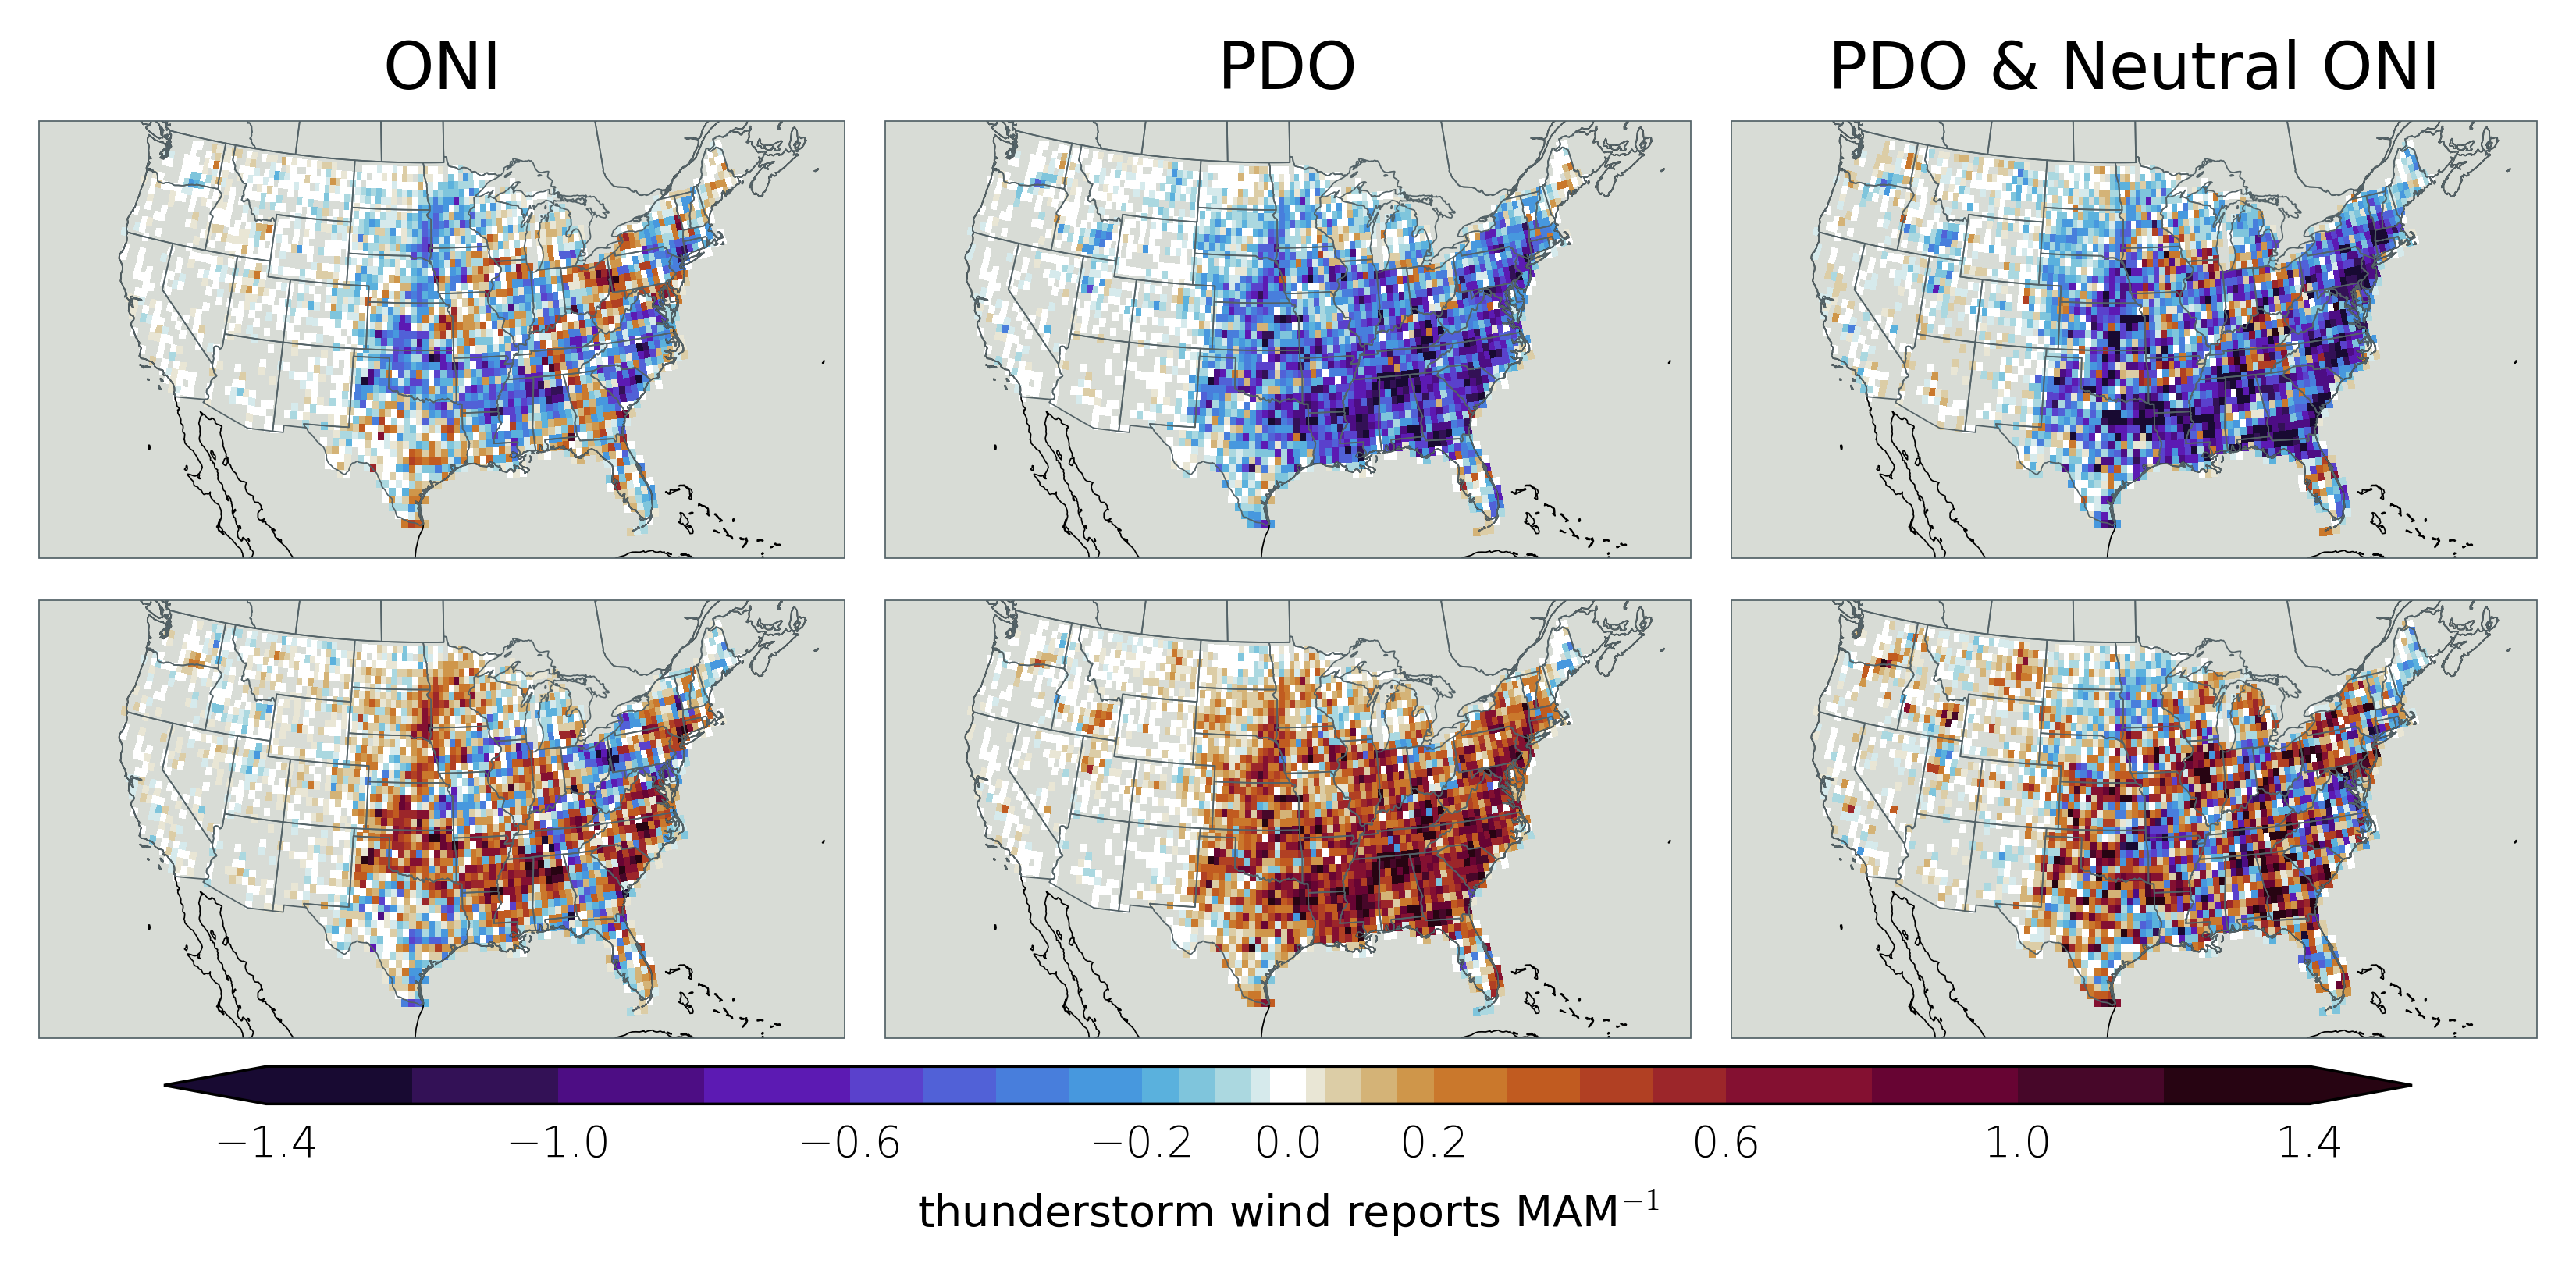

In [22]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

tstorm_wind_bounds = [-1.4, -1.2, -1, -0.8, -0.6, -0.5, -0.4, -0.3, -0.2, -0.15, -0.1, -0.05, -0.025, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4]
tstorm_wind_norm = c.BoundaryNorm(tstorm_wind_bounds, plt.get_cmap('cmr.fusion_r').N)

tornado_bounds = [-0.35, -0.3, -0.25, -0.2, -0.15, -0.125, -0.1, -0.075, -0.05, -0.0375, -0.025, -0.0125, -0.00625, 0.00625, 0.0125, 0.025, 0.0375, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35]
tornado_norm = c.BoundaryNorm(tornado_bounds, plt.get_cmap('cmr.fusion_r').N)

ax[0].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tstorm_wind_pos_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[3].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tstorm_wind_neg_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)

ax[1].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tstorm_wind_pos_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[4].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tstorm_wind_neg_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)

ax[2].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tstorm_wind_pos_pdo_neut_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[5].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tstorm_wind_neg_pdo_neut_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)

for i in range(6):
    ax[i].coastlines(lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

cax2 = plt.axes([0.05, .22, 0.9, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=tstorm_wind_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', ticks=[-1.4, -1, -0.6, -0.2, 0, 0.2, 0.6, 1, 1.4])
cbar2.set_label(r'thunderstorm wind reports MAM$^{-1}$', size=8, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('ONI')
ax[1].set_title('PDO')
ax[2].set_title('PDO & Neutral ONI')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

/tmp/ipykernel_109611/1330588563.py:12: RuntimeWarning: Mean of empty slice
  ax[0].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tornado_pos_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
/tmp/ipykernel_109611/1330588563.py:13: RuntimeWarning: Mean of empty slice
  ax[3].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tornado_neg_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
/tmp/ipykernel_109611/1330588563.py:15: RuntimeWarning: Mean of empty slice
  ax[1].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tornado_pos_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
/tmp/ipykernel_109611/1330588563.py:16: RuntimeWarning: Mean of empty slice
  ax[4].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tornado_neg_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
/t

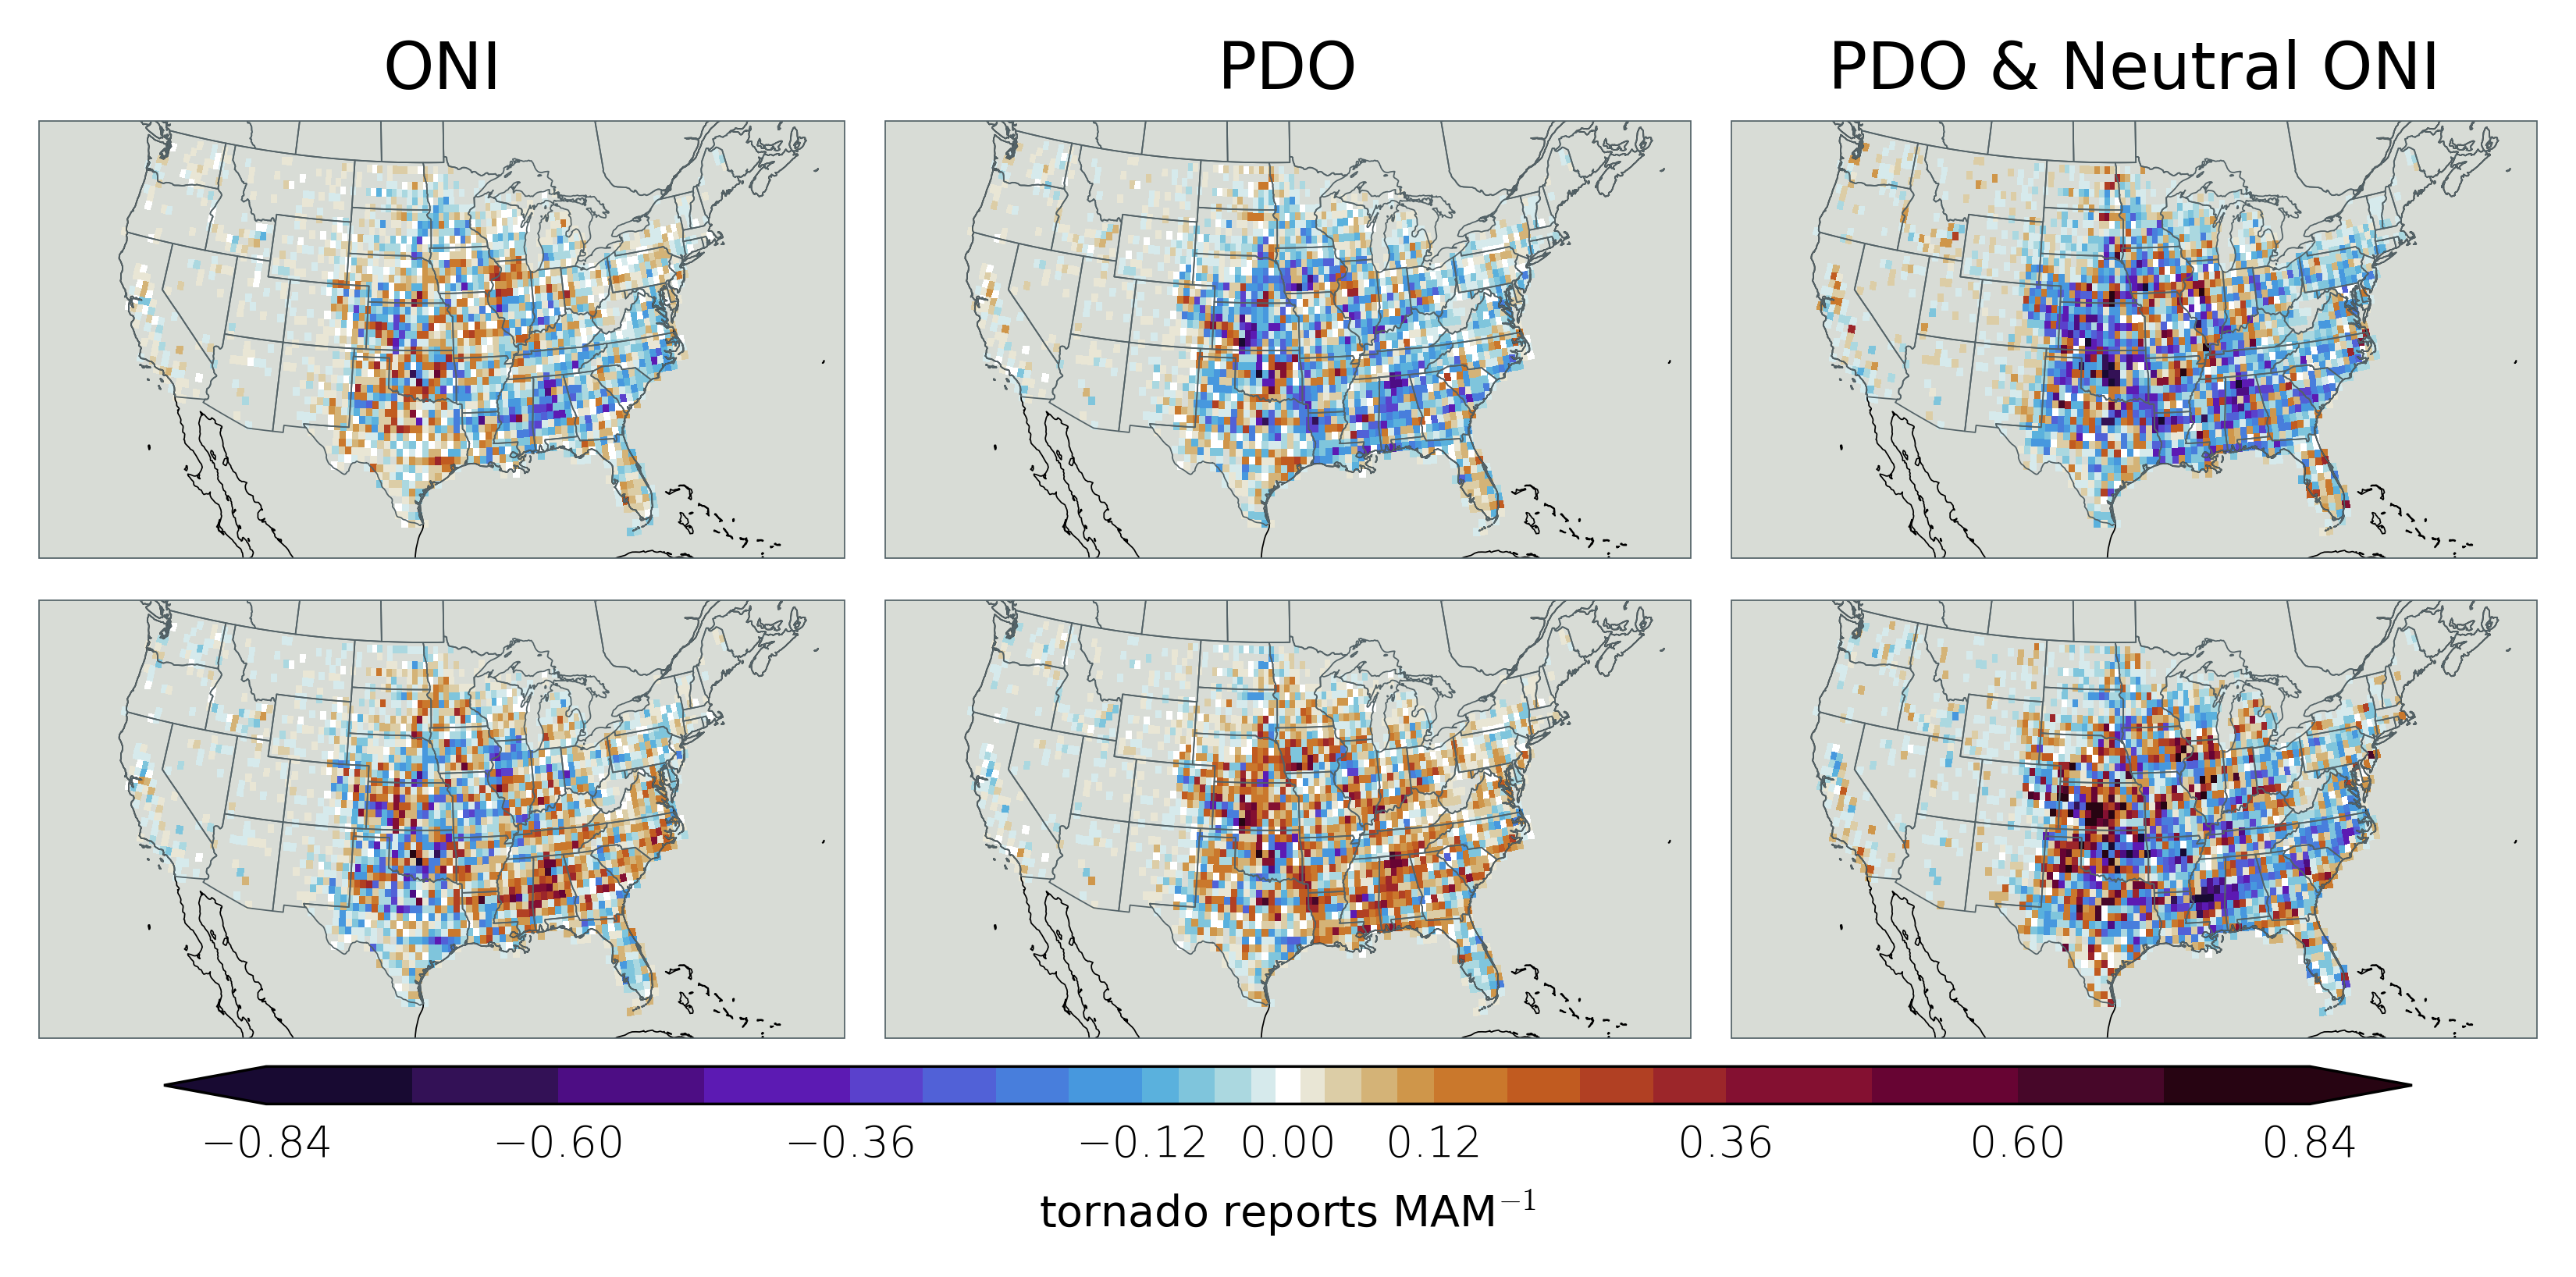

In [32]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

tstorm_wind_bounds = [-1.4, -1.2, -1, -0.8, -0.6, -0.5, -0.4, -0.3, -0.2, -0.15, -0.1, -0.05, -0.025, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4]
tstorm_wind_norm = c.BoundaryNorm(tstorm_wind_bounds, plt.get_cmap('cmr.fusion_r').N)

tornado_bounds = [-0.84, -0.72, -0.6, -0.48, -0.36, -0.3, -0.24, -0.18, -0.12, -0.09, -0.06, -0.03, -0.01, 0.01, 0.03, 0.06, 0.09, 0.12, 0.18, 0.24, 0.3, 0.36, 0.48, 0.6, 0.72, 0.84]
tornado_norm = c.BoundaryNorm(tornado_bounds, plt.get_cmap('cmr.fusion_r').N)

ax[0].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tornado_pos_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
ax[3].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tornado_neg_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)

ax[1].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tornado_pos_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
ax[4].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tornado_neg_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)

ax[2].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tornado_pos_pdo_neut_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)
ax[5].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(tornado_neg_pdo_neut_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tornado_norm)

for i in range(6):
    ax[i].coastlines(lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

cax2 = plt.axes([0.05, .22, 0.9, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=tornado_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', ticks=[-0.84, -0.6, -0.36, -0.12, 0, 0.12, 0.36, 0.6, 0.84])
cbar2.set_label(r'tornado reports MAM$^{-1}$', size=8, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('ONI')
ax[1].set_title('PDO')
ax[2].set_title('PDO & Neutral ONI')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

/tmp/ipykernel_109611/1122214301.py:12: RuntimeWarning: Mean of empty slice
  ax[0].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(hail_pos_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
/tmp/ipykernel_109611/1122214301.py:13: RuntimeWarning: Mean of empty slice
  ax[3].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(hail_neg_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
/tmp/ipykernel_109611/1122214301.py:15: RuntimeWarning: Mean of empty slice
  ax[1].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(hail_pos_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
/tmp/ipykernel_109611/1122214301.py:16: RuntimeWarning: Mean of empty slice
  ax[4].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(hail_neg_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm

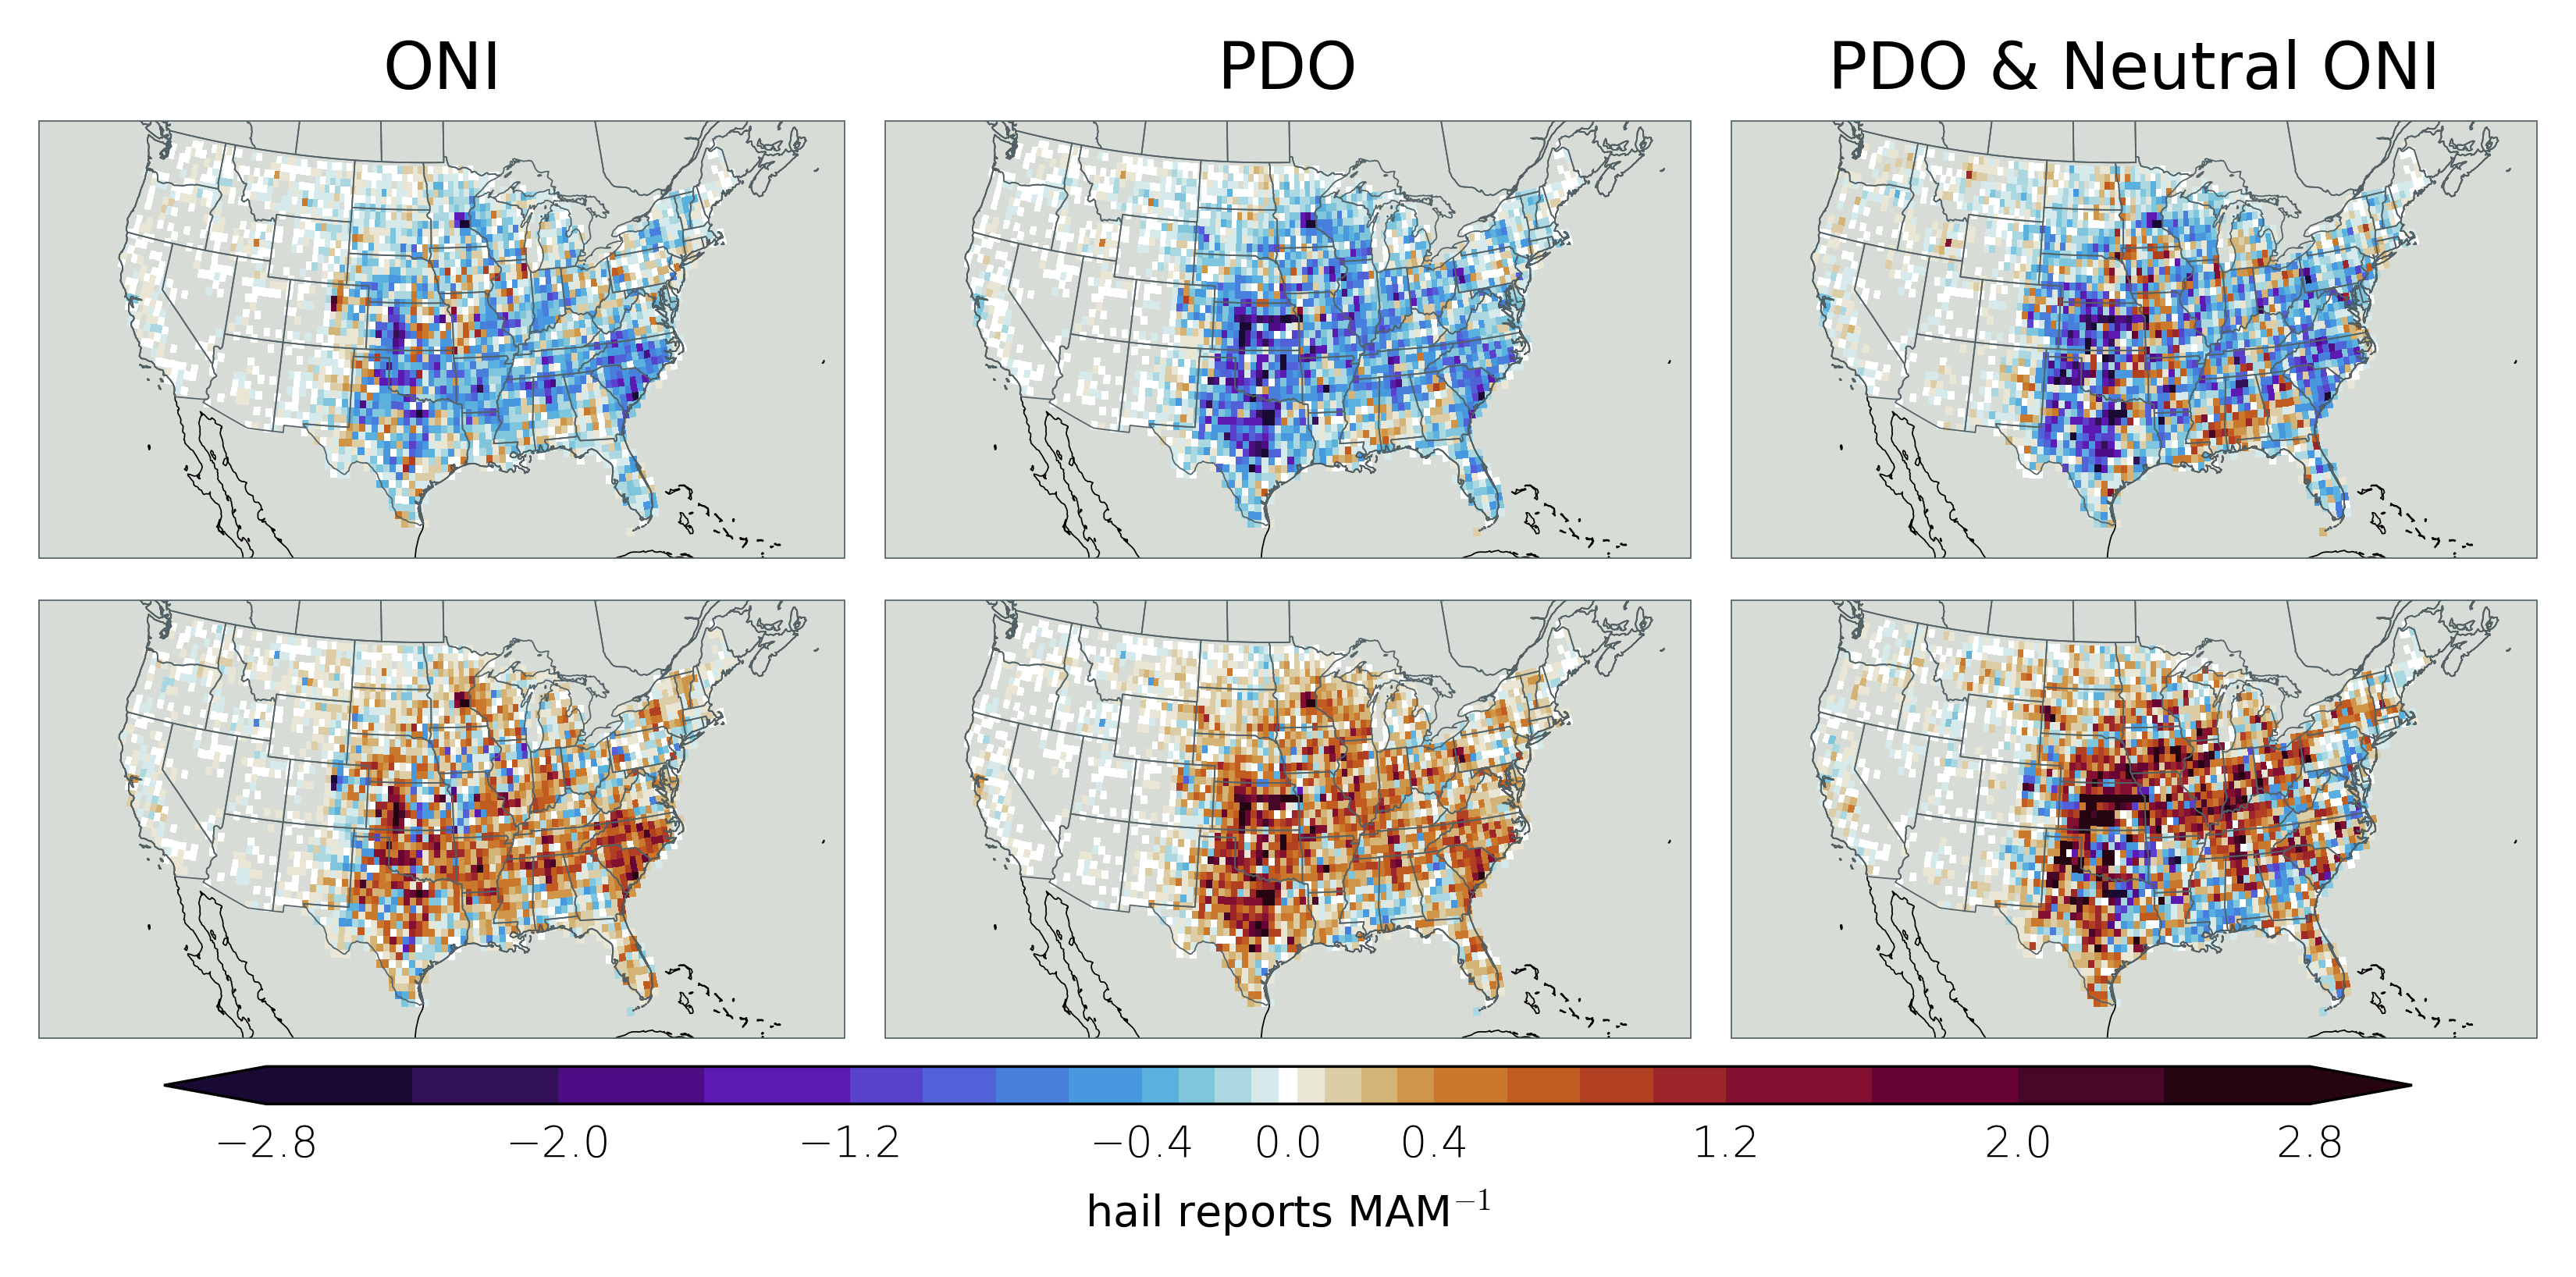

In [36]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

tstorm_wind_bounds = [-2.8, -2.4, -2, -1.6, -1.2, -1, -0.8, -0.6, -0.4, -0.3, -0.2, -0.1, -0.025, 0.025, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1.2, 1.6, 2, 2.4, 2.8]
tstorm_wind_norm = c.BoundaryNorm(tstorm_wind_bounds, plt.get_cmap('cmr.fusion_r').N)

tornado_bounds = [-0.35, -0.3, -0.25, -0.2, -0.15, -0.125, -0.1, -0.075, -0.05, -0.0375, -0.025, -0.0125, -0.00625, 0.00625, 0.0125, 0.025, 0.0375, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35]
tornado_norm = c.BoundaryNorm(tornado_bounds, plt.get_cmap('cmr.fusion_r').N)

ax[0].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(hail_pos_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[3].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(hail_neg_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)

ax[1].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(hail_pos_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[4].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(hail_neg_pdo, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)

ax[2].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(hail_pos_pdo_neut_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)
ax[5].pcolormesh(lon_edges_0_5deg, lat_edges_0_5deg, np.flipud(np.nanmean(hail_neg_pdo_neut_nino, axis=0)), transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=tstorm_wind_norm)

for i in range(6):
    ax[i].coastlines(lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].set_facecolor('xkcd:light gray')

cax2 = plt.axes([0.05, .22, 0.9, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=tstorm_wind_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', ticks=[-2.8, -2, -1.2, -0.4, 0, 0.4, 1.2, 2, 2.8])
cbar2.set_label(r'hail reports MAM$^{-1}$', size=8, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.5)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('ONI')
ax[1].set_title('PDO')
ax[2].set_title('PDO & Neutral ONI')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)